In [1]:
import dill
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [23]:
with open("experiment_config_results","rb") as current_file:
    experiment_config_results = dill.load(current_file)
with open("experiments","rb") as current_file:
    experiments = dill.load(current_file)

    
non_unique_params = np.array([experiment['parameter'] for experiment in experiments])
non_unique_config_strings = np.array([experiment['config_string'] for experiment in experiments])

par_indices = np.unique(non_unique_params,return_index=True)[1]
string_indices = np.unique(non_unique_config_strings,return_index=True)[1]

parameters = non_unique_params[np.sort(par_indices)]
config_strings = non_unique_config_strings[np.sort(string_indices)]
config_strings[0],config_strings[1],config_strings[2] = config_strings[2],config_strings[0],config_strings[1]
print(config_strings)

def str_noneguard(obj):
    if hasattr(obj,'__name__'):
        return obj.__name__
    if obj is None:
        return ''
    if isinstance(obj,list):
        return str([str_noneguard(x) for x in obj])
    return str(obj)

['CCEu, SD=4' 'CCE, SD=4' 'JSD, SD=4' 'CCE, SD=100' 'JSD, SD=100'
 'JSD(5), SD=100' 'JSD(5)' 'MSE, SD=4' 'MSE, SD=100' 'KLD, SD=4'
 'KLD, SD=100']


In [26]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

def plot_vals(i):
    fig, ax = plt.subplots(figsize=[10,6])
#     ax.set_color_cycle(['red', 'yellow', 'blue','green','black','teal'])
    ax.set_prop_cycle(color=['#4285F4','#FBBC04','#EA4335','#34A853','#000000','#46BDC6','#F4CCCC','#C9DAF8','grey','purple'])
    
    parameter = parameters[i]
    ax.set_title(parameter)
    bar=0
    all_numbers = True
    
    for config_string in config_strings:
    #     print("--------- " + config_string + " -----------")
        filtered_experiments = [ex for ex in experiments if ex['parameter']==parameter and ex['config_string']==config_string]
        if len(filtered_experiments)==0:
            continue
        mappings = np.array([x['mapping'] for x in filtered_experiments])
        x_values = [x['current_var'] for x in filtered_experiments]
        for x in x_values:
            if not isinstance(x,int) and not isinstance(x,float):
                all_numbers=False

        if not all_numbers:
            for i in range(len(x_values)):
                x_values[i] = str_noneguard(x_values[i])

        results = [result for result in np.array(experiment_config_results,dtype=object)[mappings] ]
        means = np.array([np.mean(x) for x in results])
        sigmas = np.array([np.std(x) for x in results])

    #     print("mappings")
    #     display(mappings)
    #     print("")
    #     print("results")
    #     display(results)
    #     print("")
    #     print("x_values")
    #     display(x_values)
    #     print("")
    #     print("means")
    #     display(means)
    #     print("")
    #     print("sigmas")
    #     display(sigmas)
    #     print("\n\n\n")
    #     ax.plot(x_values,means)
#         print(x_values)
        if all_numbers:
            ax.plot(x_values,means,'o-',label=config_string)
            ax.fill_between(x_values, (means-sigmas), (means+sigmas),alpha=.2)
        else:
            n=len(x_values)
            ind = np.arange(n)
            width = 0.1
            position = ind + (width*(1-n)/2) + bar*width
            ax.bar(position,means,width=width,yerr=sigmas,label=config_string)
            bar+=1
    
    ax.set_ylim([-175,100])
    if not all_numbers:
        print(x_values)
        print(ind)
#         ax.axhline(0,"black")
        ax.yaxis.set_major_locator(MultipleLocator(25))    
        ax.grid(axis="y")
        
        plt.xticks(ind, x_values)
    else:
        ax.yaxis.set_major_locator(MultipleLocator(25))
        ax.grid()
    ax.legend()

['supervised', 'supervised_2_percent', 'semi', 'semi_sup_first', 'semi_mixed', 'unsupervised']
[0 1 2 3 4 5]


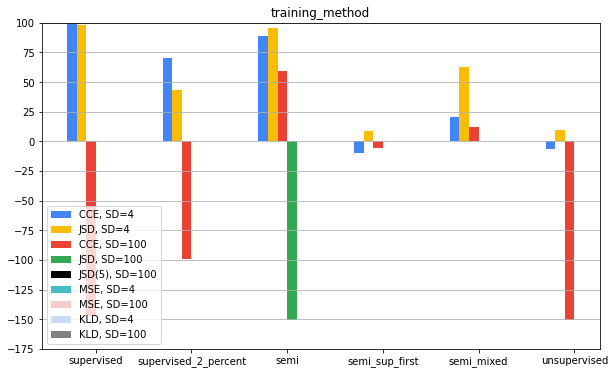

In [27]:
plot_vals(0)

["['sin', 'cos', 'linear', 'relu', 'swish']", "['relu']", "['relu', 'relu', 'relu', 'relu', 'relu']", "['sin', 'cos', 'linear']", "['sin', 'cos', 'linear', 'relu', 'sigmoid']"]
[0 1 2 3 4]


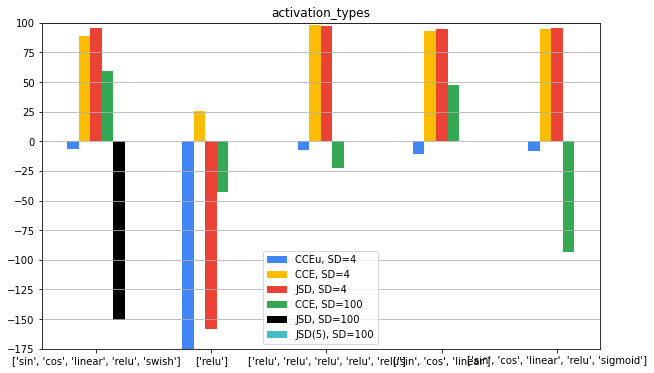

In [28]:
plot_vals(1)

['dense', 'gaussian_noise', 'gaussian_dropout', 'sqrt_softmax', 'gaussian_kernel', 'CNN', 'VAE']
[0 1 2 3 4 5 6]


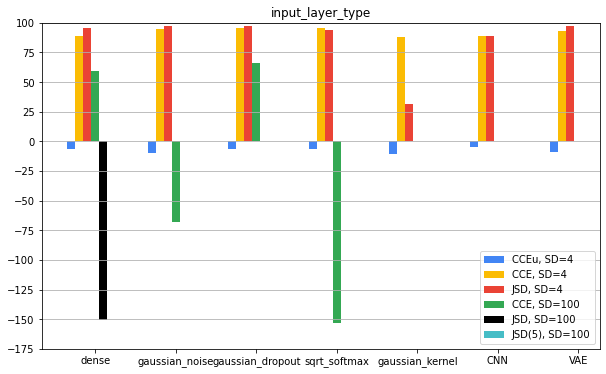

In [29]:
plot_vals(2)

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dt

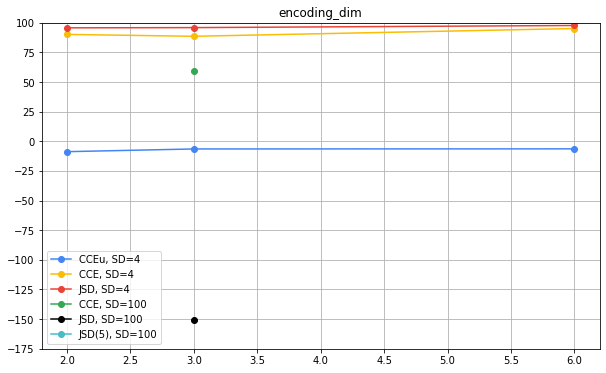

In [30]:
plot_vals(3)

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dt

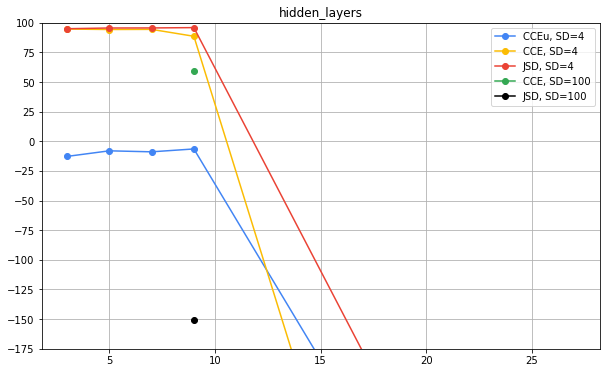

In [31]:
plot_vals(4)

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=

['', 'L2: 0.01', 'L2: 10^-4', 'L1: 0.01', 'L1: 10^-4']
[0 1 2 3 4]


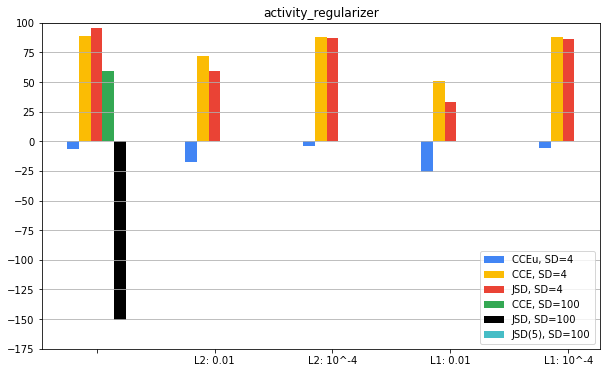

In [32]:
plot_vals(5)

['0.01/SD', '(0.01*4)/SD', '0.01/math.sqrt(SD)', '0.01', '0.05', '0.1', '0.2']
[0 1 2 3 4 5 6]


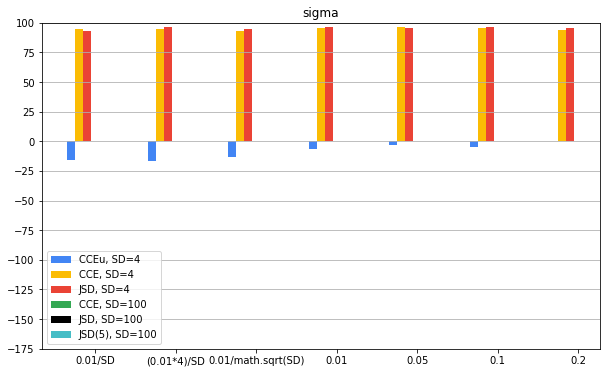

In [33]:
plot_vals(6)

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dt

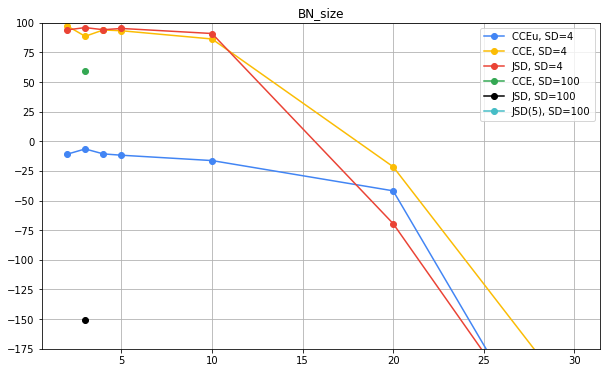

In [34]:
plot_vals(7)

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dt

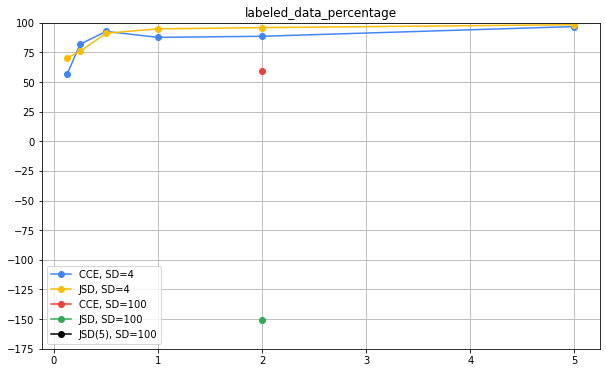

In [35]:
plot_vals(8)

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dt

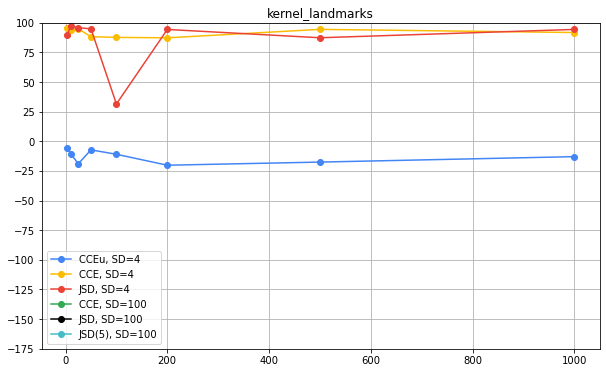

In [36]:
plot_vals(9)

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dt

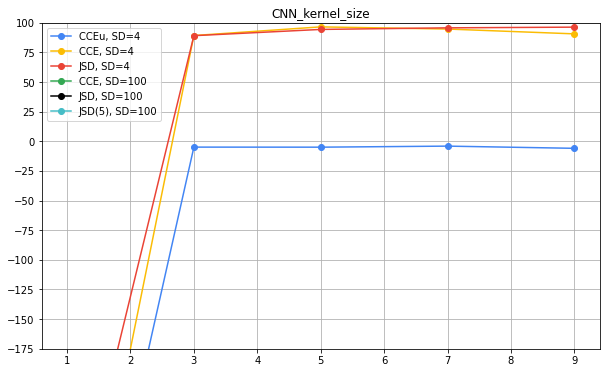

In [37]:
plot_vals(10)

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dt

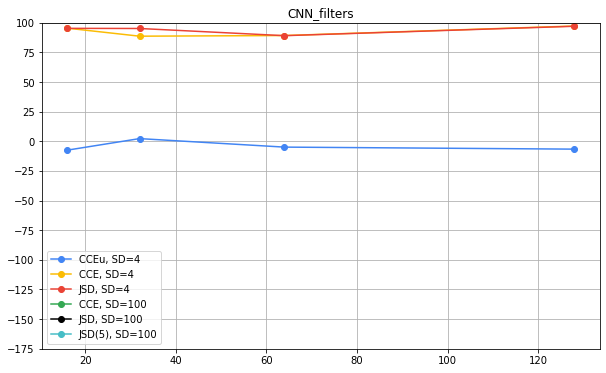

In [38]:
plot_vals(11)

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


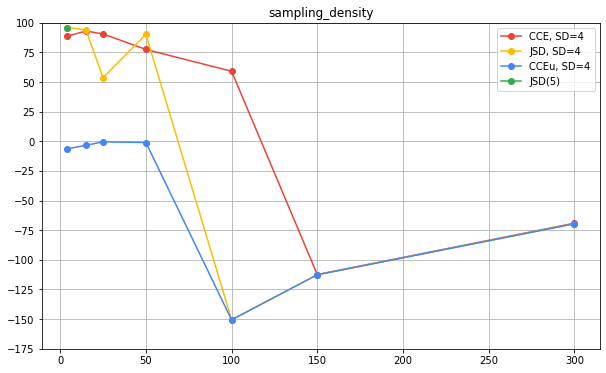

In [18]:
plot_vals(12)